In [1]:
import random
from math import prod

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Dataset

In [2]:
class NoiseScheduler:
    def __init__(self, T = 500, beta_min = 1e-4, beta_max = 0.02):
        self.T = T
        self.beta_min = beta_min
        self.beta_max = beta_max

    def get_beta_t(self, t):
        # Linear noise-scaling
        beta_t = self.beta_min + (t / self.T) * (self.beta_max - self.beta_min)
        return beta_t

    def get_alpha_t(self, t):
        beta_t = self.get_beta_t(t)
        alpha_t = 1.0 - beta_t
        return alpha_t

    def get_alpha_hat_t(self, t):
        alphas = [self.get_alpha_t(s) for s in range(1, t + 1)]
        alpha_hat = prod(alphas)
        return alpha_hat

    def add_noise(self, x_o, t):
        if t == 0:
            return x_o, 0

        alpha_t = self.get_alpha_hat_t(t)
        epsilon = np.random.normal(
            loc=0, scale=1, size=x_o.shape
        )

        noise_x = np.sqrt(alpha_t) * x_o + epsilon * np.sqrt(1.0 - alpha_t)
        return noise_x, epsilon

In [3]:
class MNISTDataset(Dataset):
    def __init__(self, train, T=500):
        self.data = MNIST(root="data/", train=train, download=True)
        self.T = T
        self.scheduler = NoiseScheduler(T)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = self.data[index][0]
        t_img = np.asarray(img)
        t_img = MNISTDataset.scale(t_img)

        t = random.randint(1, self.T)

        noise_img, epsilon = self.scheduler.add_noise(t_img, t)

        noise_img = torch.from_numpy(noise_img).float().unsqueeze(0)
        epsilon = torch.from_numpy(epsilon).float().unsqueeze(0)
        t = torch.Tensor([t])
        t_img = torch.from_numpy(t_img).unsqueeze(0).float()

        return t_img, noise_img, epsilon, t

    @staticmethod
    def scale(t_img):
        t_img = t_img / 255
        t_img = t_img * 2 - 1
        return t_img

    @staticmethod
    def inverse_transform(output):
        output = (output + 1) / 2
        output = output * 255
        output = np.uint8(output)
        noise_img = Image.fromarray(output)
        return noise_img

In [4]:
train_data = MNISTDataset(train=True)
val_data = MNISTDataset(train=False)

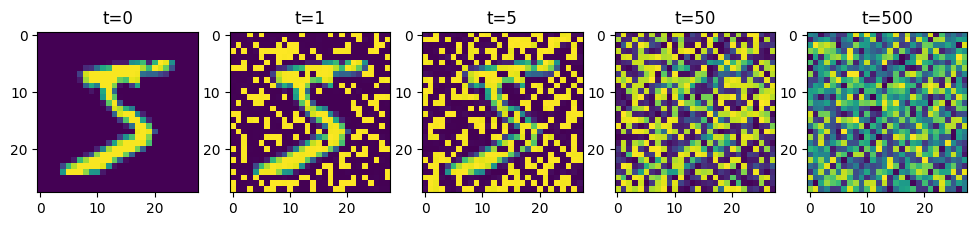

In [5]:
Ts = [0, 1, 5, 50, 500]
scheduler = NoiseScheduler()
img = train_data.data[0][0]
img = np.asarray(img)

f, axarr = plt.subplots(1, len(Ts), figsize=(12,6))

for idx, t in enumerate(Ts):
    o, _ = scheduler.add_noise(MNISTDataset.scale(img), t)
    axarr[idx].imshow(MNISTDataset.inverse_transform(o))
    axarr[idx].set_title(f"t={t}")

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, num_dims):
        super().__init__()
        self.num_dims = num_dims

    def forward(self, t):
        # NOTE: t need to be of shape [batch_size, 1]
        d = self.num_dims // 2
        i = torch.arange(0, d, device=t.device)
        i = i.unsqueeze(0)
        div_term = 1 / (10000 **((i / (d - 1))))
        emb = t / div_term
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)        
        return emb


class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


class TimeEmbedding(nn.Module):
    def __init__(self, time_dim):
        super().__init__()

        self.pe = PositionalEncoding(time_dim)
        self.linear = nn.Linear(time_dim, time_dim)
        self.act = Swish()

    def forward(self, t):
        p = self.pe(t)
        p = self.linear(p)
        p = self.act(p)
        return p


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, groups=4, kernel_size=3, stride=1, padding=1):
        super().__init__()

        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.gn = nn.GroupNorm(num_groups=groups, num_channels=out_channels)
        self.act = nn.SiLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.gn(x)
        x = self.act(x)
        return x


class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block_1 = ConvBlock(in_channels, out_channels)
        self.block_2 = ConvBlock(out_channels, out_channels)
        self.time_emb = TimeEmbedding(out_channels)

        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x, t):
        h = self.block_1(x)
        h += self.time_emb(t)[:, :, None, None]
        h = self.block_2(h)

        return h + self.shortcut(x)


class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels, groups=4):
        super().__init__()
        self.conv = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=4, stride=2, padding=1)
        self.gn = nn.GroupNorm(num_groups=groups, num_channels=out_channels)
        self.act = nn.SiLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.gn(x)
        x = self.act(x)
        return x


class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, num_heads=4):
        super().__init__()
        self.att = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)

    def forward(self, x):
        b, c, h, w = x.shape

        x = torch.permute(x, (0, 2, 3, 1))  # b, h, w, c 
        x = x.view((b, h * w, c))
        x, _ = self.att(query=x, key=x, value=x)

        x = x.view((b, h, w, c))
        x = torch.permute(x, (0, 3, 1, 2))
        return x


class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.res_block = ResNetBlock(in_channels, in_channels)
        self.att = AttentionBlock(in_channels)
        self.down_block = ConvBlock(in_channels, out_channels, stride=2)

    def forward(self, x, t):
        x = self.res_block(x, t)
        x = self.att(x)
        x = self.down_block(x)
        return x


class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.res_block = ResNetBlock(in_channels, in_channels)
        self.att = AttentionBlock(in_channels)
        self.down_block = UpConv(in_channels, out_channels)

    def forward(self, x, t):
        x = self.res_block(x, t)
        x = self.att(x)
        x = self.down_block(x)
        return x

In [7]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.init_conv = ConvBlock(1, 4)

        self.block_1 = DownBlock(4, 8)
        self.block_2 = DownBlock(8, 16)

        self.block_3 = UpBlock(16, 8)
        self.block_4 = UpBlock(8, 4)

        self.conv_output = nn.Conv2d(4, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, x, t):
        x = self.init_conv(x)

        x_1 = self.block_1(x, t)  # b, 16, 14, 14
        x_2 = self.block_2(x_1, t)  # b, 32, 7, 7

        x_3 = self.block_3(x_2, t)  # b, 16, 14, 14
        x_3 = x_3 + x_1

        x_4 = self.block_4(x_3, t)  # b, 8, 28, 28
        x_4 = x_4 + x

        x_4 = self.conv_output(x_4)

        return x_4

In [8]:
batch_size = 64

device = "cuda"
seed = 42
lr = 1e-2
num_epochs = 5

torch.random.manual_seed(seed)
model = UNet()
model = model.to(device)

In [9]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4)

In [10]:
optimizer = Adam(model.parameters(), lr=lr)

In [11]:
for epoch in range(num_epochs):
    train_loss, val_loss = 0.0, 0.0
    for t_img, x_noise, epsilon, t in train_loader:
        model.zero_grad()

        t_img = t_img.to(device)
        x_noise = x_noise.to(device)
        epsilon = epsilon.to(device)
        t = t.to(device)

        epsilon_t = model(x_noise, t)
        alpha_hat_t = torch.Tensor([scheduler.get_alpha_hat_t(x[0]) for x in t.int().detach().cpu().numpy()]).to(device)
        alpha_hat_t = alpha_hat_t.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)

        o = torch.sqrt(alpha_hat_t) * t_img + torch.sqrt(1.0 - alpha_hat_t) * epsilon_t

        loss = nn.functional.mse_loss(o, epsilon)
        loss.backward()
        optimizer.step()

        train_loss += loss.detach().cpu().numpy()

    with torch.no_grad():
        for t_img, x_noise, epsilon, t in val_loader:
            t_img = t_img.to(device)
            x_noise = x_noise.to(device)
            epsilon = epsilon.to(device)
            t = t.to(device)

            epsilon_t = model(x_noise, t)
            alpha_hat_t = torch.Tensor([scheduler.get_alpha_hat_t(x[0]) for x in t.int().detach().cpu().numpy()]).to(device)
            alpha_hat_t = alpha_hat_t.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)

            o = torch.sqrt(alpha_hat_t) * t_img + torch.sqrt(1.0 - alpha_hat_t) * epsilon_t

            loss = nn.functional.mse_loss(o, epsilon)
            val_loss += loss.detach().cpu().numpy()

    train_loss = round(np.mean(train_loss) / len(train_loader), 4)
    val_loss = round(np.mean(val_loss) / len(val_loader), 4)

    print(f"----- Epoch {epoch} -----")
    print(f"Training loss: {train_loss}")
    print(f"Val loss: {val_loss}")

----- Epoch 0 -----
Training loss: 0.3167000114917755
Val loss: 0.20170000195503235
----- Epoch 1 -----
Training loss: 0.19120000302791595
Val loss: 0.1623000055551529
----- Epoch 2 -----
Training loss: 0.16099999845027924
Val loss: 0.15379999577999115
----- Epoch 3 -----
Training loss: 0.14970000088214874
Val loss: 0.14069999754428864
----- Epoch 4 -----
Training loss: 0.14589999616146088
Val loss: 0.14110000431537628


In [12]:
x_t = torch.randn((1, 1, 28, 28)).to(device)  # x_T
scheduler = NoiseScheduler()

with torch.no_grad():
    for t in range(500, 0, -1):
        if t == 0:
            z = 0
        else:
            z = torch.randn((1, 1, 28, 28)).to(device)

        alpha_t = scheduler.get_alpha_t(t)
        alpha_hat_t = scheduler.get_alpha_hat_t(t)
        sigma_t = np.sqrt(scheduler.get_beta_t(t))

        epsilon_t = model(x_t, torch.Tensor([t]).to(device).unsqueeze(0))
        x_t = 1.0 / np.sqrt(alpha_t) * (x_t - (1.0 - alpha_t) / np.sqrt(1.0 - alpha_hat_t) * epsilon_t) + sigma_t * z

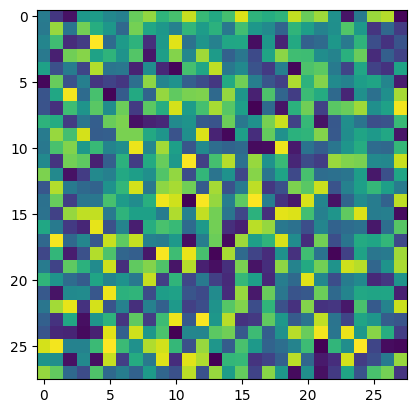

In [13]:
img = MNISTDataset.inverse_transform(x_t.cpu().squeeze(0).squeeze(0))
plt.imshow(img)